Als Vorverarbeitung wollen wir die folgenden winkelerhaltenden Strategien zur Distanzminimierung untersuchen. 

Dazu skalieren wir alle Kreise so, dass
   - ihre Größe maximal wird, ohne dass dabei irgendwo ein Overlap entsteht 
   - der kleinste Abstand 0 wird, ohne Beachtung von Überlappung anderer Knoten (-> Skalierung um Faktor der kleinsten relative Distanz)
   - ihr durchschnittlicher relativer Abstand 0 würde, wenn man negative Abstände einbeziehen würde (-> Skalierung um Faktor der mittleren Distanz)
   - das p-Quantil der relativen Distanzen 0 wird.

In [85]:
import numpy as np
import pandas as pd
import itertools
from utils import input
from utils import score

In [137]:
input_file = "input_files/Deutschlands_Nachbarn.txt"
output_file = "result_files/Deutschlands_Nachbarn_score_4803.116061.txt"

input_nodes, edges_df, k = input.read_to_df(input_file)
#input_nodes['radius'] = np.sqrt(input_nodes.value)
output_nodes = score.read_to_df(output_file)

edges = list(zip(edges_df.node_0.to_list(), edges_df.node_1.to_list()))
n, start_overlap, start_distance, start_angle, start_score = score.calc_score(input_nodes, output_nodes, edges, k)
print(f"Score: {start_score:.2f} (n={n}, k={k}, overlap={start_overlap:.2f}, distance={start_distance:.2f}, angle={start_angle:.2f})\n")

Score: 4803.12 (n=10, k=17, overlap=0.87, distance=4.69, angle=8.30)


In [138]:
edges_df['R'] = edges_df.apply(lambda x: output_nodes.at[x.node_0, 'radius'] + output_nodes.at[x.node_1, 'radius'], axis=1)
edges_df['target_angle'] = edges_df.apply(lambda x: score.calc_angle(input_nodes, x.node_0, x.node_1), axis=1)

edges_df['angle'] = edges_df.apply(lambda x: score.calc_angle(output_nodes, x.node_0, x.node_1), axis=1)
edges_df['length'] = edges_df.apply(lambda x: 
                                    np.hypot(output_nodes.at[x.node_0, 'x'] - output_nodes.at[x.node_1, 'x'], output_nodes.at[x.node_0, 'y'] - output_nodes.at[x.node_1, 'y']),
                                    axis=1)

edges_df['angle_diff'] = edges_df.apply(lambda x: 
                                        min(abs(x.target_angle - x.angle), 2 - abs(x.target_angle - x.angle)) * 100,
                                        axis=1)
edges_df['distance'] = (edges_df['length'] / edges_df['R']) * 100 - 100
edges_df.loc[edges_df['distance'] < 0, 'distance'] = 0

edges_df

,node_0,node_1,R,target_angle,angle,length,angle_diff,distance
0,D,DK,1318.274587,-0.472975,-0.462882,1308.303099,1.009287,0.000000
1,D,PL,1812.324537,-0.967920,0.955768,2059.880636,7.631134,13.659590
2,D,CZ,1561.327728,0.912208,0.764302,1547.862884,14.790590,0.000000
3,D,A,1456.525497,0.770119,0.587347,1444.100269,18.277235,0.000000
4,D,CH,1341.801789,0.376394,0.422611,1341.214132,4.621629,0.000000
5,D,F,1630.799283,0.158016,0.200680,1717.637353,4.266405,5.324878
6,D,L,1200.440740,0.116875,0.120326,1190.021850,0.345088,0.000000
7,D,B,1423.693628,0.036566,0.034852,1441.123882,0.171475,1.224298
8,D,NL,1494.816735,-0.060224,-0.123743,1481.784502,6.351955,0.000000
9,NL,B,727.798704,0.397584,0.472942,721.724772,7.535848,0.000000


In [139]:
edges_df.describe()

,R,target_angle,angle,length,angle_diff,distance
count,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000
mean,1135.595457,0.067516,0.285545,1176.765597,8.301201,4.690086
std,415.266964,0.642240,0.572498,431.628495,6.863484,10.812250
min,433.422709,-0.967920,-0.862673,431.242913,0.171475,0.000000
25%,781.889414,-0.472975,0.034852,827.021893,3.627083,0.000000
50%,1200.440740,0.158016,0.422611,1190.021850,6.351955,0.000000
75%,1456.525497,0.397584,0.764302,1444.100269,14.790590,1.224298
max,1812.324537,0.970611,0.960844,2059.880636,21.508946,41.086318


In [140]:
overlaps = [(node_a, node_b, score.calc_overlap(output_nodes, node_a, node_b)) for node_a, node_b in itertools.combinations(output_nodes.index, 2)]

In [141]:
sorted([a for a in overlaps if a[2] > 0], key=lambda x: x[2], reverse=True)

[('D', 'NL', 0.008718281329873248),
 ('B', 'F', 0.008680789875213677),
 ('D', 'L', 0.008679220117223635),
 ('D', 'CZ', 0.00862397011793821),
 ('D', 'A', 0.008530730984659661),
 ('NL', 'B', 0.008345620484380962),
 ('D', 'DK', 0.007564045097805495),
 ('CZ', 'PL', 0.006433260869701545),
 ('B', 'L', 0.005029260907516285),
 ('L', 'F', 0.002844148952411177),
 ('D', 'CH', 0.0004379615747106527),
 ('A', 'CZ', 0.00014468265241019337)]

In [142]:
o = 0.0031158536597162357 * 100
d = edges_df.distance.mean()
a = edges_df.angle_diff.mean()
def score_plot(n, k, o, d, a):
    return 1000. * (n + k) / (1 + 0.1 * (o ** 2) + 0.05 * (d ** 2) + 0.05 * (a ** 2))
score_plot(n, k, o, d, a)

4860.441614995816

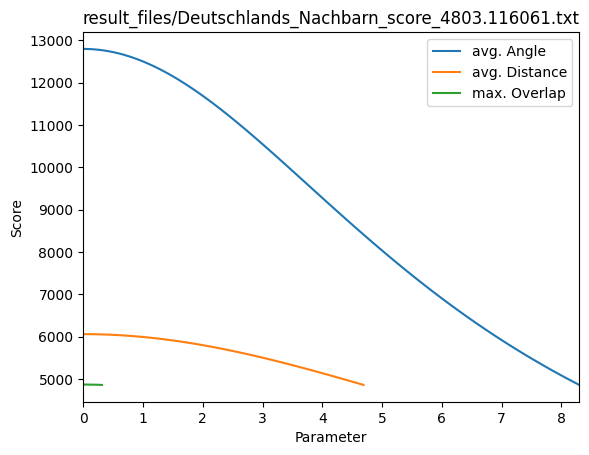

In [148]:
import matplotlib.pyplot as plt
plt.plot(np.linspace(0, a, 100), score_plot(n, k, o, d, np.linspace(0, a, 100)), label="avg. Angle")
plt.plot(np.linspace(0, d, 100), score_plot(n, k, o, np.linspace(0, d, 100), a), label="avg. Distance")
plt.plot(np.linspace(0, o, 100), score_plot(n, k, np.linspace(0, o, 100), d, a), label="max. Overlap")
plt.title(output_file)
plt.ylabel("Score")
plt.xlabel("Parameter")
plt.xlim(0, a)
plt.legend()
plt.show()

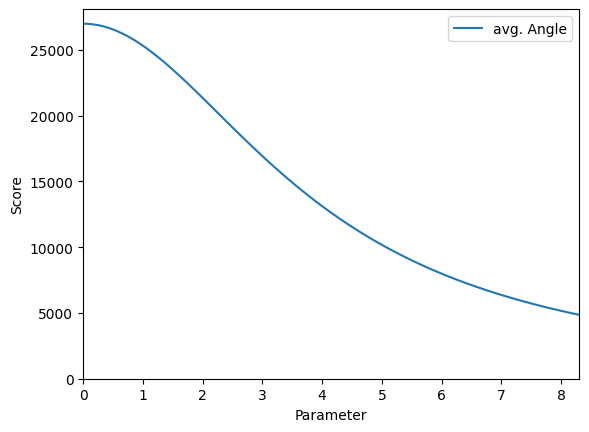

In [146]:
plt.plot(np.linspace(0, a, 100), score_plot(n, k, np.linspace(0, o, 100), np.linspace(0, d, 100), np.linspace(0, a, 100)), label="avg. Angle")
plt.ylabel("Score")
plt.xlabel("Parameter")
plt.xlim(0, a)
plt.ylim(0)
plt.legend()
plt.show()